<a href="https://colab.research.google.com/github/Migaalee/Deep_learning/blob/main/DeepNeuralNetworks_Migla_Notebook2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 - ADNE 2022 - Notebook 2



## Data pre-processing

### Import all required libraries

In [ ]:
import glob
import numpy as np
import tensorflow as tf
from google.colab import files
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import matplotlib.pyplot as plt


#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
import io
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import mean_absolute_error
sns.set()
from tensorflow import keras
from datetime import datetime
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model, Sequential
from keras.constraints import maxnorm
from tensorflow.keras.layers import GlobalAveragePooling1D, Input, BatchNormalization, MaxPooling2D, Flatten, Conv2D, Dense, Activation, Dropout, concatenate, Reshape, UpSampling1D, Conv1D, MaxPooling1D
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed,Input, Reshape, UpSampling1D, Conv1D
from keras.layers.recurrent import LSTM
import os
from keras.layers import Embedding
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)
from keras.layers import LeakyReLU


In [ ]:
from keras.layers import Embedding
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Auxilary functions

In [ ]:
def read_npy(fname):
    """fname should be a npy file; função auxiliar que vai ser usada pela função 'map' para ler o conteúdo de cada um dos ficheiros do fnames_dataset e criar um novo dataset com estes conteúdos."""
    fname = fname.decode()
    recData = np.load(fname)
    return recData.astype(np.float32)

def cut_data(x):
  N = tf.shape(x)[1]
  r = tf.random.uniform(shape=[], maxval = (N - L), dtype = tf.dtypes.int32)
  return x[:, N - r - L: N - r]

class PositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(PositionEmbedding, self).__init__()
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[1]
        batchS = tf.shape(x)[0]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        positions = tf.expand_dims(positions, axis = 0)
        positions = tf.repeat(positions, batchS, axis=0)
        return x + positions

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)







### Import data for training, validation and testing

In [ ]:
os.chdir("/content/drive/MyDrive/adneDataAlunos/")
dir = './'
list_train_files = glob.glob(dir + "trainAlunos/" + '*.npy')
list_valid_files = glob.glob(dir + "validacaoAlunos/" + '*.npy')
list_test_files = glob.glob(dir + "testeAlunos/" + '*.npy')
data_train = tf.data.Dataset.from_tensor_slices(list_train_files) #creates a dataset with a separate element for each row of the input tensor, this will be important to put our different examples in separate tensors
data_valid = tf.data.Dataset.from_tensor_slices(list_valid_files)
data_test = tf.data.Dataset.from_tensor_slices(list_test_files)
data_train = data_train.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32]))
data_valid = data_valid.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32]))
data_test = data_test.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32]))



### Visualisation of one tensor

In [ ]:
it = iter(data_train) #creates an object which can be iterated one element at a time
ex = next(it) # returns the next item in an iterator
ex
#valid: shape=(2, 24002), train: shape=(2, 48000), test: shape=(2, 41325)

In [ ]:
ex[0].shape
aux=ex[0]
plt.plot(aux[0,:5000]/1000)
plt.plot(aux[1,:5000])

### Segment data into pieces

In [ ]:
L=2000
data_train_cut = data_train.map(cut_data)
data_test_cut = data_test.map(cut_data)
data_valid_cut = data_valid.map(cut_data)

### STFT transformation

#### This STFT transformed data (cut into 2000) will be used for FFN

In [10]:
frame_length=256
frame_step =32
frame_length1=128
frame_step1 =32
frame_length2=64
frame_step2 =32
data_train_stft = data_train_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length, frame_step = frame_step)), x[1]))
data_test_stft = data_test_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length, frame_step = frame_step)), x[1]))
data_valid_stft = data_valid_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length, frame_step = frame_step)), x[1]))
data_train_stft1 = data_train_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length1, frame_step = frame_step1)), x[1]))
data_test_stft1 = data_test_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length1, frame_step = frame_step1)), x[1]))
data_valid_stft1 = data_valid_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length1, frame_step = frame_step1)), x[1]))
data_train_stft2 = data_train_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length2, frame_step = frame_step2)), x[1]))
data_test_stft2 = data_test_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length2, frame_step = frame_step2)), x[1]))
data_valid_stft2 = data_valid_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length2, frame_step = frame_step2)), x[1]))



data_train_stft_nonv = data_train.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length2, frame_step = frame_step2)), x[1]))
data_test_stft_nonv = data_test.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length2, frame_step = frame_step2)), x[1]))
data_valid_stft_nonv = data_valid.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length2, frame_step = frame_step2)), x[1]))

####  This STFT transformed data will be used for RNN, CNN, Transformers

In [11]:
data_size_var_train = data_train.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length, frame_step = frame_step))), x[1]))
data_size_var_test = data_test.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length, frame_step = frame_step))), x[1]))
data_size_var_valid = data_valid.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length, frame_step = frame_step))), x[1]))

data_size_var_train1 = data_train.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length1, frame_step = frame_step1))), x[1]))
data_size_var_test1 = data_test.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length1, frame_step = frame_step1))), x[1]))
data_size_var_valid1 = data_valid.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length1, frame_step = frame_step1))), x[1]))

data_size_var_train2 = data_train.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length2, frame_step = frame_step2))), x[1]))
data_size_var_test2 = data_test.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length2, frame_step = frame_step2))), x[1]))
data_size_var_valid2 = data_valid.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length2, frame_step = frame_step2))), x[1]))

### Define batch size for segmented data

In [12]:
batch_size=2
input_train = data_train_stft.batch(batch_size)
input_test = data_test_stft.batch(batch_size)
input_valid = data_valid_stft.batch(batch_size)

input_train1 = data_train_stft1.batch(batch_size)
input_test1 = data_test_stft1.batch(batch_size)
input_valid1 = data_valid_stft1.batch(batch_size)

input_train2 = data_train_stft2.batch(batch_size)
input_test2 = data_test_stft2.batch(batch_size)
input_valid2 = data_valid_stft2.batch(batch_size)


input_train_n = data_train_stft_nonv.batch(batch_size)
input_test_n= data_test_stft_nonv.batch(batch_size)
input_valid_n = data_valid_stft_nonv.batch(batch_size)


# Define batch size and add padding for variable size data

In [13]:
batch_size = 2
k = 129 #shape of x of input_variable_train
k1 = 65
k2 = 33

input_variable_train = data_size_var_train.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k])), [None]))
input_variable_test = data_size_var_test.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k])), [None]))
input_variable_valid = data_size_var_valid.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k])), [None]))

input_variable_train1 = data_size_var_train1.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k1])), [None]))
input_variable_test1 = data_size_var_test1.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k1])), [None]))
input_variable_valid1 = data_size_var_valid1.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k1])), [None]))

input_variable_train2 = data_size_var_train2.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k2])), [None]))
input_variable_test2 = data_size_var_test2.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k2])), [None]))
input_variable_valid2 = data_size_var_valid2.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k2])), [None]))





### Check input shape for cut data

In [14]:
it1 = iter(data_train_stft_nonv)
ex1 = next(it1)
ex1 #input_train: shape=(2, 55, 129) data_size_var_train shape=(1493, 129), input_variable_train shape=(2, 1493, 129)
# data_size_var_train shape=(1493, 129) data_size_var_train1 shape=(1497, 65) data_size_var_train2 shape=(1499, 33)

(<tf.Tensor: shape=(1499, 33), dtype=float32, numpy=
 array([[2.0636738e+03, 2.5522839e+03, 2.6418686e+01, ..., 2.1865089e+01,
         1.5356467e+01, 4.5193604e+01],
        [1.0697292e+03, 9.1138281e+02, 8.7901929e+02, ..., 4.3534233e+01,
         5.9799389e+01, 2.9157715e+01],
        [4.1605977e+03, 3.2868027e+03, 1.8058660e+03, ..., 9.5098900e+01,
         6.0583408e+01, 3.7170166e+01],
        ...,
        [4.3056631e+03, 2.1212683e+03, 9.9435675e+02, ..., 7.2889389e+01,
         3.1945162e+01, 1.2435303e+01],
        [2.8414766e+03, 6.4247565e+02, 3.6327698e+03, ..., 7.4961624e+01,
         5.9420261e+01, 9.7985840e+00],
        [2.4060811e+04, 1.7013295e+04, 4.8234961e+03, ..., 3.9270763e+01,
         2.2794537e+01, 1.8216797e+01]], dtype=float32)>,
 <tf.Tensor: shape=(48000,), dtype=float32, numpy=array([4., 4., 4., ..., 4., 4., 4.], dtype=float32)>)

### Define input shape

In [15]:
itera = tf.compat.v1.data.Iterator.from_structure(tf.compat.v1.data.get_output_types(input_train),
                                           tf.compat.v1.data.get_output_shapes(input_train))
train_init_op = itera.make_initializer(input_train)

features, labels = itera.get_next()
sample = itera.get_next()
sample
input_shape = np.shape((sample)[0])[1:]
print(input_shape)

Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
(55, 129)


In [16]:
itera1 = tf.compat.v1.data.Iterator.from_structure(tf.compat.v1.data.get_output_types(input_train1),
                                           tf.compat.v1.data.get_output_shapes(input_train1))
train_init_op1 = itera1.make_initializer(input_train1)

features, labels = itera1.get_next()
sample1 = itera1.get_next()
sample1
input_shape1 = np.shape((sample1)[0])[1:]
print(input_shape1)

(59, 65)


In [17]:
itera2 = tf.compat.v1.data.Iterator.from_structure(tf.compat.v1.data.get_output_types(input_train2),
                                           tf.compat.v1.data.get_output_shapes(input_train2))
train_init_op2 = itera1.make_initializer(input_train2)

features, labels = itera2.get_next()
sample2 = itera2.get_next()
sample2
input_shape2 = np.shape((sample2)[0])[1:]
print(input_shape2)

(61, 33)


## Define variable input size

In [18]:
iterat = tf.compat.v1.data.Iterator.from_structure(tf.compat.v1.data.get_output_types(input_variable_train),
                                           tf.compat.v1.data.get_output_shapes(input_variable_train))
train_init_op2 = iterat.make_initializer(input_variable_train)

features2, labels2 = iterat.get_next()
sample2 = iterat.get_next()
sample2
#input_shape2 = np.shape((sample2)[1])[1] #48126
#input_shape2 = np.shape((sample2)[1])[0] #2
input_shape2 = np.shape((sample2)[1])[1:] #48126
print(input_shape2)

(48126,)


## FeedForward Neural network

Explain what was tried

### Defining hyperparameters

In [19]:
NUM_EPOCHS = 100 #Increase epochs if you do not see a flatlined loss function
#Add batch normalization
INIT_LR  = 0.0001 #change to 0.001 after
BS = 32 #batch size
opt= SGD(learning_rate=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
opt2 = tf.optimizers.Adam(learning_rate = INIT_LR)
from keras.callbacks import EarlyStopping  
early_stopping =EarlyStopping(monitor='loss', patience=2) 

### Model

In [ ]:
def feedforward_yes_upsampling_dense2(opt, input_train, input_valid, input_test):
    model = Sequential() #object of sequencial class
    model.add(Flatten(input_shape=input_shape2)) #we define the input shape, check shape after stft transformation
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(512))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(256))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(128)) 
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
   # model.add(Dense(256)) #removed this
   # model.add(BatchNormalization())
   # model.add(LeakyReLU(alpha=0.1))
    #model.add(Dense(64)) 
    #model.add(BatchNormalization())
    #model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization()) # standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks
    #output layer
    model.add(Dense(100)) #because we have 4 y outputs, but also because it does not start at 0, we should reshape here to have an output of 10000 (2000x5)
    model.add(Activation("softmax"))

    model.add(Reshape((20, 5))) #output is all cut data (segment size) and target numbers
    model.add(UpSampling1D(100)) #tried 100 instead

    model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['sparse_categorical_accuracy']) #multiclass classification problems, categorical crossentropy loss is the loss function of choice.

    history = model.fit(input_train, validation_data=input_valid,
                    batch_size=BS, 
                    epochs=NUM_EPOCHS, callbacks=[early_stopping])
    # plotting the metrics
    plt.subplot(2, 1, 1)
    plt.title('Sparse Crossentropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
		# plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
    score = model.evaluate(input_test, verbose=0) #evaluate based on test dataset, which was not used for training and validation
    return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1]) 

### Running the model

In [ ]:
ffn1=feedforward_yes_upsampling_dense(opt2, input_train, input_valid, input_test)

In [52]:
def feedforward_yes_upsampling_dense(opt, input_train, input_valid, input_test):
    model = Sequential() #object of sequencial class
    model.add(Flatten(input_shape=input_shape)) #we define the input shape, check shape after stft transformation
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(512))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(256))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(128)) 
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
   # model.add(Dense(256)) #removed this
   # model.add(BatchNormalization())
   # model.add(LeakyReLU(alpha=0.1))
    #model.add(Dense(64)) 
    #model.add(BatchNormalization())
    #model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization()) # standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks
    #output layer
    model.add(Dense(100)) #because we have 4 y outputs, but also because it does not start at 0, we should reshape here to have an output of 10000 (2000x5)
    model.add(Activation("softmax"))

    model.add(Reshape((20, 5))) #output is all cut data (segment size) and target numbers
    model.add(UpSampling1D(100)) #tried 100 instead

    model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['sparse_categorical_accuracy']) #multiclass classification problems, categorical crossentropy loss is the loss function of choice.

    history = model.fit(input_train, validation_data=input_valid,
                    batch_size=BS, 
                    epochs=NUM_EPOCHS, callbacks=[early_stopping])
    # plotting the metrics
    plt.subplot(2, 1, 1)
    plt.title('Sparse Crossentropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
		# plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
    score = model.evaluate(input_test, verbose=0) #evaluate based on test dataset, which was not used for training and validation
    return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1]) 

In [57]:
NUM_EPOCHS = 100 #Increase epochs if you do not see a flatlined loss function
#Add batch normalization
INIT_LR  = 0.0001 #change to 0.001 after
BS = 32 #batch size
opt= SGD(learning_rate=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
opt2 = tf.optimizers.Adam(learning_rate = INIT_LR)
from keras.callbacks import EarlyStopping  
early_stopping =EarlyStopping(monitor='loss', patience=2) 

In [55]:
def feedforward_yes_upsampling_dense1(opt, input_train, input_valid, input_test):
    model = Sequential() #object of sequencial class
    model.add(Flatten(input_shape=input_shape1)) #we define the input shape, check shape after stft transformation
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(512))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(256))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(128)) 
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
   # model.add(Dense(256)) #removed this
   # model.add(BatchNormalization())
   # model.add(LeakyReLU(alpha=0.1))
    #model.add(Dense(64)) 
    #model.add(BatchNormalization())
    #model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization()) # standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks
    #output layer
    model.add(Dense(100)) #because we have 4 y outputs, but also because it does not start at 0, we should reshape here to have an output of 10000 (2000x5)
    model.add(Activation("softmax"))

    model.add(Reshape((20, 5))) #output is all cut data (segment size) and target numbers
    model.add(UpSampling1D(100)) #tried 100 instead

    model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['sparse_categorical_accuracy']) #multiclass classification problems, categorical crossentropy loss is the loss function of choice.

    history = model.fit(input_train, validation_data=input_valid,
                    batch_size=BS, 
                    epochs=NUM_EPOCHS, callbacks=[early_stopping])
    # plotting the metrics
    plt.subplot(2, 1, 1)
    plt.title('Sparse Crossentropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
		# plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
    score = model.evaluate(input_test, verbose=0) #evaluate based on test dataset, which was not used for training and validation
    return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1]) 

In [56]:
def feedforward_yes_upsampling_dense2(opt, input_train, input_valid, input_test):
    model = Sequential() #object of sequencial class
    model.add(Flatten(input_shape=input_shape2)) #we define the input shape, check shape after stft transformation
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(512))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(256))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(128)) 
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
   # model.add(Dense(256)) #removed this
   # model.add(BatchNormalization())
   # model.add(LeakyReLU(alpha=0.1))
    #model.add(Dense(64)) 
    #model.add(BatchNormalization())
    #model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization()) # standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks
    #output layer
    model.add(Dense(100)) #because we have 4 y outputs, but also because it does not start at 0, we should reshape here to have an output of 10000 (2000x5)
    model.add(Activation("softmax"))

    model.add(Reshape((20, 5))) #output is all cut data (segment size) and target numbers
    model.add(UpSampling1D(100)) #tried 100 instead

    model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['sparse_categorical_accuracy']) #multiclass classification problems, categorical crossentropy loss is the loss function of choice.

    history = model.fit(input_train, validation_data=input_valid,
                    batch_size=BS, 
                    epochs=NUM_EPOCHS, callbacks=[early_stopping])
    # plotting the metrics
    plt.subplot(2, 1, 1)
    plt.title('Sparse Crossentropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
		# plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
    score = model.evaluate(input_test, verbose=0) #evaluate based on test dataset, which was not used for training and validation
    return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1]) 

Epoch 1/100
1250/1250 [==============================] - 94s 66ms/step - loss: 1.5946 - sparse_categorical_accuracy: 0.3152 - val_loss: 1.5556 - val_sparse_categorical_accuracy: 0.4255
Epoch 2/100
1250/1250 [==============================] - 81s 65ms/step - loss: 1.3951 - sparse_categorical_accuracy: 0.4260 - val_loss: 1.5062 - val_sparse_categorical_accuracy: 0.4418
Epoch 3/100
1250/1250 [==============================] - 77s 61ms/step - loss: 1.2947 - sparse_categorical_accuracy: 0.4622 - val_loss: 1.3227 - val_sparse_categorical_accuracy: 0.4792
Epoch 4/100
1250/1250 [==============================] - 77s 61ms/step - loss: 1.2375 - sparse_categorical_accuracy: 0.4762 - val_loss: 1.3481 - val_sparse_categorical_accuracy: 0.4987
Epoch 5/100
1250/1250 [==============================] - 77s 61ms/step - loss: 1.2100 - sparse_categorical_accuracy: 0.4879 - val_loss: 1.2629 - val_sparse_categorical_accuracy: 0.5073
Epoch 6/100
1250/1250 [==============================] - 76s 61ms/step - lo

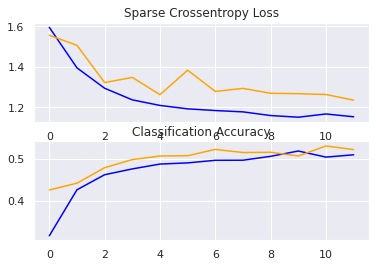

In [54]:
ffn1=feedforward_yes_upsampling_dense(opt2, input_train, input_valid, input_test)

Epoch 1/100
1250/1250 [==============================] - 59s 44ms/step - loss: 1.5620 - sparse_categorical_accuracy: 0.3344 - val_loss: 1.6360 - val_sparse_categorical_accuracy: 0.3920
Epoch 2/100
1250/1250 [==============================] - 57s 46ms/step - loss: 1.3518 - sparse_categorical_accuracy: 0.4554 - val_loss: 1.4026 - val_sparse_categorical_accuracy: 0.5076
Epoch 3/100
1250/1250 [==============================] - 55s 44ms/step - loss: 1.2682 - sparse_categorical_accuracy: 0.4895 - val_loss: 1.3232 - val_sparse_categorical_accuracy: 0.5050
Epoch 4/100
1250/1250 [==============================] - 53s 43ms/step - loss: 1.2267 - sparse_categorical_accuracy: 0.4819 - val_loss: 1.2247 - val_sparse_categorical_accuracy: 0.5269
Epoch 5/100
1250/1250 [==============================] - 54s 43ms/step - loss: 1.1755 - sparse_categorical_accuracy: 0.5056 - val_loss: 1.2848 - val_sparse_categorical_accuracy: 0.5347
Epoch 6/100
1250/1250 [==============================] - 54s 43ms/step - lo

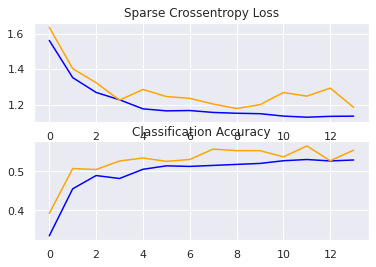

In [58]:
ffn1=feedforward_yes_upsampling_dense1(opt2, input_train1, input_valid1, input_test1)

Epoch 1/100
1250/1250 [==============================] - 48s 35ms/step - loss: 1.4681 - sparse_categorical_accuracy: 0.3870 - val_loss: 1.5835 - val_sparse_categorical_accuracy: 0.4232
Epoch 2/100
1250/1250 [==============================] - 44s 35ms/step - loss: 1.3175 - sparse_categorical_accuracy: 0.4561 - val_loss: 1.4478 - val_sparse_categorical_accuracy: 0.4730
Epoch 3/100
1250/1250 [==============================] - 43s 34ms/step - loss: 1.2272 - sparse_categorical_accuracy: 0.4913 - val_loss: 1.2728 - val_sparse_categorical_accuracy: 0.5076
Epoch 4/100
1250/1250 [==============================] - 44s 35ms/step - loss: 1.2000 - sparse_categorical_accuracy: 0.4917 - val_loss: 1.3575 - val_sparse_categorical_accuracy: 0.4807
Epoch 5/100
1250/1250 [==============================] - 43s 35ms/step - loss: 1.1801 - sparse_categorical_accuracy: 0.5019 - val_loss: 1.2854 - val_sparse_categorical_accuracy: 0.4895
Epoch 6/100
1250/1250 [==============================] - 43s 35ms/step - lo

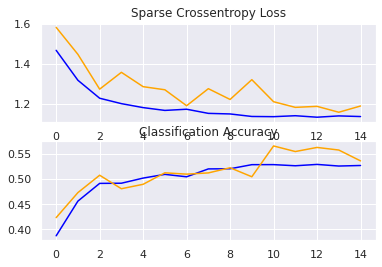

In [59]:
ffn2=feedforward_yes_upsampling_dense2(opt2, input_train2, input_valid2, input_test2)

In [65]:
def feedforward_yes_upsampling_dense3(opt, input_train, input_valid, input_test):
    model = Sequential() #object of sequencial class
    model.add(Flatten(input_shape=input_shape2)) #we define the input shape, check shape after stft transformation
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(512))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(256))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(128)) 
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(256)) #removed this
   # model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    #model.add(Dense(64)) 
    #model.add(BatchNormalization())
   # model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization()) # standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks
    #output layer
    model.add(Dense(100)) #because we have 4 y outputs, but also because it does not start at 0, we should reshape here to have an output of 10000 (2000x5)
    model.add(Activation("softmax"))

    model.add(Reshape((20, 5))) #output is all cut data (segment size) and target numbers
    model.add(UpSampling1D(100)) #tried 100 instead

    model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['sparse_categorical_accuracy']) #multiclass classification problems, categorical crossentropy loss is the loss function of choice.

    history = model.fit(input_train, validation_data=input_valid,
                    batch_size=BS, 
                    epochs=NUM_EPOCHS, callbacks=[early_stopping])
    # plotting the metrics
    plt.subplot(2, 1, 1)
    plt.title('Sparse Crossentropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
		# plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
    score = model.evaluate(input_test, verbose=0) #evaluate based on test dataset, which was not used for training and validation
    return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1]) 

Epoch 1/100
1250/1250 [==============================] - 50s 36ms/step - loss: 1.4258 - sparse_categorical_accuracy: 0.4161 - val_loss: 1.4706 - val_sparse_categorical_accuracy: 0.4564
Epoch 2/100
1250/1250 [==============================] - 47s 38ms/step - loss: 1.2568 - sparse_categorical_accuracy: 0.4732 - val_loss: 1.4602 - val_sparse_categorical_accuracy: 0.4644
Epoch 3/100
1250/1250 [==============================] - 44s 35ms/step - loss: 1.2196 - sparse_categorical_accuracy: 0.4822 - val_loss: 1.3696 - val_sparse_categorical_accuracy: 0.4682
Epoch 4/100
1250/1250 [==============================] - 46s 37ms/step - loss: 1.1904 - sparse_categorical_accuracy: 0.4898 - val_loss: 1.2916 - val_sparse_categorical_accuracy: 0.4762
Epoch 5/100
1250/1250 [==============================] - 46s 37ms/step - loss: 1.1770 - sparse_categorical_accuracy: 0.5014 - val_loss: 1.3968 - val_sparse_categorical_accuracy: 0.4935
Epoch 6/100
1250/1250 [==============================] - 47s 37ms/step - lo

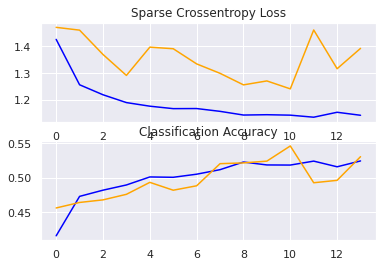

In [66]:
ffn3=feedforward_yes_upsampling_dense3(opt2, input_train2, input_valid2, input_test2)



## Recurrent Neural network

In [37]:
NUM_EPOCHS = 100 #Increase epochs if you do not see a flatlined loss function
#Add batch normalization
INIT_LR  = 0.1 #change to 0.001 after
BS = 32 #batch size
opt= SGD(learning_rate=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
opt2 = tf.optimizers.Adam(learning_rate = INIT_LR)
from keras.callbacks import EarlyStopping  
early_stopping =EarlyStopping(monitor='loss', patience=2) 

In [76]:
def rnn1(opt, input_train, input_valid, input_test):
    model = Sequential() 
    model.add(LSTM(50, input_shape=input_shape2))
    model.add(Activation("LeakyReLU"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(LSTM(50))
    model.add(Activation("LeakyReLU"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten()) 
    #output layer
    model.add(Dense(100)) #because we have 4 y outputs, but also because it does not start at 0, we should reshape here to have an output of 10000 (2000x5)
    model.add(Activation("softmax"))
    model.add(Reshape((20, 5))) #output is all cut data (segment size) and target numbers
    model.add(UpSampling1D(100)) #Add upsampling layer in order to obtain one layer for each point

    model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['sparse_categorical_accuracy']) #metrics=["categorical_accuracy"]) #model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])


    history = model.fit(input_train2, validation_data=input_valid2,
                    batch_size=BS, 
                    epochs=NUM_EPOCHS, callbacks=[early_stopping])
    # plotting the metrics
    plt.subplot(2, 1, 1)
    plt.title('Sparse Crossentropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
		# plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
    score = model.evaluate(input_test2, verbose=0) #evaluate based on test dataset, which was not used for training and validation
    return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1]) 

In [ ]:
rnn= rnn1(opt2, input_train2, input_valid2,input_test)

In [87]:
def rnn (opt, inputs, input_variable_valid, input_variable_test):
  inputs = Input(shape=(None,33),name='inputs')
  #inputs_L = Input(shape=[],name='inputs2')
  #layer= LSTM(128,return_sequences=True)(inputs) 
  #layer = Activation("relu")(layer)
  #layer= LSTM(32,return_sequences=True)(inputs)
  #layer = BatchNormalization(axis=-1)(layer)
  #layer = Activation("LeakyReLU")(layer)
  layer= LSTM(32,return_sequences=True)(inputs)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  layer= LSTM(32,return_sequences=True)(inputs)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  #layer = Dropout(0.2)(layer)
  layer = TimeDistributed(Dense(150))(layer)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=15)(layer)
  L = tf.cast(tf.reduce_max(inputs), tf.int32)
  output = Dense(5)(layer)
  #output = layer[:,:L]
  model = Model(inputs = inputs , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_train2, validation_data=input_valid2, batch_size=BS, epochs=NUM_EPOCHS, verbose=1)
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_test2, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1])


In [88]:
rnn= rnn(opt2, input_train2, input_valid2,input_test)

Epoch 1/100


InvalidArgumentError: ignored

In [40]:
print(input_shape2)

(61, 33)


In [41]:
def rnn_variable(opt, inputs, input_variable_valid, input_variable_test):
  inputs = Input(shape=(None,33),name='inputs')
  inputs_L = Input(shape=[],name='inputs2')
  #layer= LSTM(128,return_sequences=True)(inputs) 
  #layer = Activation("relu")(layer)
  #layer= LSTM(32,return_sequences=True)(inputs)
  #layer = BatchNormalization(axis=-1)(layer)
  #layer = Activation("LeakyReLU")(layer)
  layer= LSTM(32,return_sequences=True)(inputs)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  layer= LSTM(32,return_sequences=True)(inputs)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  #layer = Dropout(0.2)(layer)
  layer = TimeDistributed(Dense(150))(layer)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=15)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train2, validation_data=input_variable_valid2, batch_size=BS, epochs=NUM_EPOCHS, verbose=1)
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test2, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1])

In [39]:
rnn= rnn_variable(opt2, input_variable_train2, input_variable_valid2,input_variable_test2)

Epoch 1/100
   5/1250 [..............................] - ETA: 2:31:00 - loss: 5.4143 - sparse_categorical_accuracy: 0.2186

KeyboardInterrupt: ignored

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [23]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.0117802859999756
GPU (s):
0.041570825999997396
GPU speedup over CPU: 72x


In [42]:
print(input_shape2)

(61, 33)


In [47]:
def rnn(opt, input_variable_train, input_variable_valid, input_variable_test):
  inputs=Input(shape=(61,33),name='inputs')
  inputs=Flatten(inputs)
  layer= LSTM(128,return_sequences=True)(inputs) 
  layer = Activation("LeakyReLU")(layer)
  layer= LSTM(64,return_sequences=True)(inputs)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  layer= LSTM(32,return_sequences=True)(inputs) 
  layer = Activation("LeakyReLU")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Dropout(0.2)(layer)
  output = TimeDistributed(Dense(15))(layer)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=15)(layer)
  model = Model(inputs = inputs, outputs= output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train, validation_data=input_variable_valid, batch_size=BS, epochs=NUM_EPOCHS, verbose=1)
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1])

In [55]:
def cnn(opt, input_train, input_valid, input_test):
    model = Sequential() 
    model.add(Conv1D(32, 3, padding="same", input_shape=input_shape2))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Flatten()) 

    #output layer
    model.add(Dense(100)) #because we have 4 y outputs, but also because it does not start at 0, we should reshape here to have an output of 10000 (2000x5)
    model.add(Activation("softmax"))
    model.add(Reshape((20, 5))) #output is all cut data (segment size) and target numbers
    model.add(UpSampling1D(100)) #Add upsampling layer in order to obtain one layer for each point

    model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['sparse_categorical_accuracy']) #metrics=["categorical_accuracy"]) #model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])


    history = model.fit(input_train, validation_data=input_valid,
                    batch_size=BS, 
                    epochs=NUM_EPOCHS)
    # plotting the metrics
    plt.subplot(2, 1, 1)
    plt.title('Sparse Crossentropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
		# plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
    score = model.evaluate(input_test, verbose=0) #evaluate based on test dataset, which was not used for training and validation
    return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1]) 

In [56]:
cnn=cnn(opt, input_train, input_valid, input_test)

Epoch 1/100
 162/1250 [==>...........................] - ETA: 7:18 - loss: 2.0967 - sparse_categorical_accuracy: 0.2977

KeyboardInterrupt: ignored

## Convolutional Neural network

### Define hyperparameters

In [62]:
NUM_EPOCHS = 100 #Increase epochs if you do not see a flatlined loss function
#Add batch normalization
INIT_LR  = 0.0001 #change to 0.001 after
BS = 32 #batch size
opt= SGD(learning_rate=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
opt2 = tf.optimizers.Adam(learning_rate = INIT_LR)
from keras.callbacks import EarlyStopping  
early_stopping =EarlyStopping(monitor='loss', patience=2) 

In [63]:
def cnn(opt, input_train, input_valid, input_test):
    model = Sequential() 
    model.add(Conv1D(64, 3, padding="same", input_shape=input_shape2))
    model.add(Activation("LeakyReLU"))
    model.add(BatchNormalization())
    #model.add(Dropout(0.25))
    model.add(Conv1D(32, 3, padding="same"))
    model.add(Activation("LeakyReLU"))
    model.add(BatchNormalization())
   # model.add(Dropout(0.1))
    model.add(Flatten()) 
    #output layer
    model.add(Dense(100)) #because we have 4 y outputs, but also because it does not start at 0, we should reshape here to have an output of 10000 (2000x5)
    model.add(Activation("softmax"))
    model.add(Reshape((20, 5))) #output is all cut data (segment size) and target numbers
    model.add(UpSampling1D(100)) #Add upsampling layer in order to obtain one layer for each point

    model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['sparse_categorical_accuracy']) #metrics=["categorical_accuracy"]) #model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])


    history = model.fit(input_train, validation_data=input_valid,
                    batch_size=BS, 
                    epochs=NUM_EPOCHS, callbacks=[early_stopping])
    # plotting the metrics
    plt.subplot(2, 1, 1)
    plt.title('Sparse Crossentropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
		# plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
    score = model.evaluate(input_test, verbose=0) #evaluate based on test dataset, which was not used for training and validation
    return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1]) 

Epoch 1/100
1250/1250 [==============================] - 81s 15ms/step - loss: 1.7852 - sparse_categorical_accuracy: 0.3069 - val_loss: 1.4686 - val_sparse_categorical_accuracy: 0.4345
Epoch 2/100
1250/1250 [==============================] - 25s 20ms/step - loss: 1.2514 - sparse_categorical_accuracy: 0.5139 - val_loss: 1.2173 - val_sparse_categorical_accuracy: 0.5635
Epoch 3/100
1250/1250 [==============================] - 22s 17ms/step - loss: 1.0600 - sparse_categorical_accuracy: 0.6151 - val_loss: 1.1078 - val_sparse_categorical_accuracy: 0.6306
Epoch 4/100
1250/1250 [==============================] - 19s 15ms/step - loss: 0.9742 - sparse_categorical_accuracy: 0.6502 - val_loss: 1.0273 - val_sparse_categorical_accuracy: 0.6470
Epoch 5/100
1250/1250 [==============================] - 23s 18ms/step - loss: 0.9160 - sparse_categorical_accuracy: 0.6724 - val_loss: 1.0105 - val_sparse_categorical_accuracy: 0.6370
Epoch 6/100
1250/1250 [==============================] - 18s 14ms/step - lo

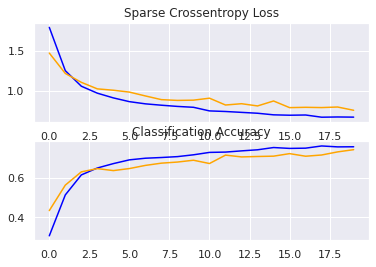

In [64]:
cnn=cnn(opt, input_train2, input_valid2, input_test2)

In [67]:
def cnn1(opt, input_train, input_valid, input_test):
    model = Sequential() 
    model.add(Conv1D(64, 3, padding="same", input_shape=input_shape2))
    model.add(Activation("LeakyReLU"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(32, 3, padding="same"))
    model.add(Activation("LeakyReLU"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten()) 
    #output layer
    model.add(Dense(100)) #because we have 4 y outputs, but also because it does not start at 0, we should reshape here to have an output of 10000 (2000x5)
    model.add(Activation("softmax"))
    model.add(Reshape((20, 5))) #output is all cut data (segment size) and target numbers
    model.add(UpSampling1D(100)) #Add upsampling layer in order to obtain one layer for each point

    model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['sparse_categorical_accuracy']) #metrics=["categorical_accuracy"]) #model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])


    history = model.fit(input_train, validation_data=input_valid,
                    batch_size=BS, 
                    epochs=NUM_EPOCHS, callbacks=[early_stopping])
    # plotting the metrics
    plt.subplot(2, 1, 1)
    plt.title('Sparse Crossentropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
		# plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
    score = model.evaluate(input_test, verbose=0) #evaluate based on test dataset, which was not used for training and validation
    return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1]) 

Epoch 1/100
1250/1250 [==============================] - 22s 15ms/step - loss: 2.0627 - sparse_categorical_accuracy: 0.2662 - val_loss: 1.5768 - val_sparse_categorical_accuracy: 0.3743
Epoch 2/100
1250/1250 [==============================] - 18s 15ms/step - loss: 1.5279 - sparse_categorical_accuracy: 0.4178 - val_loss: 1.2810 - val_sparse_categorical_accuracy: 0.5484
Epoch 3/100
1250/1250 [==============================] - 18s 14ms/step - loss: 1.2737 - sparse_categorical_accuracy: 0.5177 - val_loss: 1.1404 - val_sparse_categorical_accuracy: 0.6016
Epoch 4/100
1250/1250 [==============================] - 18s 15ms/step - loss: 1.1431 - sparse_categorical_accuracy: 0.5787 - val_loss: 1.1036 - val_sparse_categorical_accuracy: 0.6226
Epoch 5/100
1250/1250 [==============================] - 18s 14ms/step - loss: 1.0831 - sparse_categorical_accuracy: 0.6001 - val_loss: 1.0747 - val_sparse_categorical_accuracy: 0.6206
Epoch 6/100
1250/1250 [==============================] - 18s 14ms/step - lo

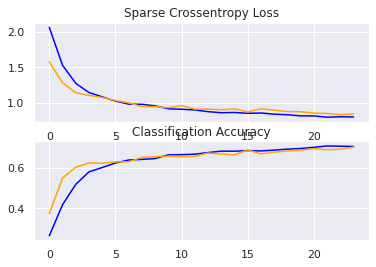

In [66]:
cnn=cnn1(opt, input_train2, input_valid2, input_test2)

In [55]:
inputs = Input(shape=(None,129),name='inputs')
inputs_all = Input(shape=[], name='inputs2')
inputs_variable=(inputs,inputs_all)
inputs_variable[0]

<KerasTensor: shape=(None, None, 129) dtype=float32 (created by layer 'inputs')>

In [45]:
inputs1 = Input(shape=(None,65),name='inputs')
inputs_all1 = Input(shape=[], name='inputs2')
inputs_variable1=(inputs1,inputs_all1)
inputs_variable1[0]

<KerasTensor: shape=(None, None, 65) dtype=float32 (created by layer 'inputs')>

In [46]:
inputs2 = Input(shape=(None,33),name='inputs')
inputs_all2 = Input(shape=[], name='inputs2')
inputs_variable2=(inputs2,inputs_all2)
inputs_variable2[0]

<KerasTensor: shape=(None, None, 33) dtype=float32 (created by layer 'inputs')>

In [ ]:
NUM_EPOCHS = 100 #Increase epochs if you do not see a flatlined loss function
#Add batch normalization
INIT_LR  = 0.0001 #change to 0.001 after
BS = 32 #batch size
opt= SGD(learning_rate=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
opt2 = tf.optimizers.Adam(learning_rate = INIT_LR)
from keras.callbacks import EarlyStopping  
early_stopping =EarlyStopping(monitor='loss', patience=2) 

In [89]:
def cnn_variable(opt, inputs, input_variable_valid,input_variable_test):
  inputs = Input(shape=(None,33),name='inputs')
  inputs_L = Input(shape=[],name='inputs2')
  layer_c = Conv1D(256, 1, padding="same")(inputs)
  layer = Activation("LeakyReLU")(layer_c)
  #layer = Dropout(0.5)(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  layer = Conv1D(128, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  #layer = Dropout(0.2)(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  layer = Conv1D(256, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  #layer = Dropout(0.2)(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  #layer = Dropout(0.2)(layer)
  #layer = Flatten()(layer)
  #layer = Dropout(0.2)(layer)
  layer = TimeDistributed(Dense(150))(layer)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=15)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train2, validation_data=input_variable_valid2, batch_size=BS, epochs=NUM_EPOCHS, verbose=1, callbacks=[early_stopping])
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test2, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1]) 

Epoch 1/100
1250/1250 [==============================] - 57s 45ms/step - loss: 3.4814 - sparse_categorical_accuracy: 0.2384 - val_loss: 2.1343 - val_sparse_categorical_accuracy: 0.2609
Epoch 2/100
1250/1250 [==============================] - 27s 21ms/step - loss: 2.0250 - sparse_categorical_accuracy: 0.2582 - val_loss: 1.8104 - val_sparse_categorical_accuracy: 0.2608
Epoch 3/100
1250/1250 [==============================] - 19s 15ms/step - loss: 1.8524 - sparse_categorical_accuracy: 0.2631 - val_loss: 1.8480 - val_sparse_categorical_accuracy: 0.2634
Epoch 4/100
1250/1250 [==============================] - 19s 15ms/step - loss: 1.8099 - sparse_categorical_accuracy: 0.2638 - val_loss: 1.7161 - val_sparse_categorical_accuracy: 0.2688
Epoch 5/100
1250/1250 [==============================] - 31s 25ms/step - loss: 1.7542 - sparse_categorical_accuracy: 0.2707 - val_loss: 1.6850 - val_sparse_categorical_accuracy: 0.2845
Epoch 6/100
1250/1250 [==============================] - 29s 23ms/step - lo

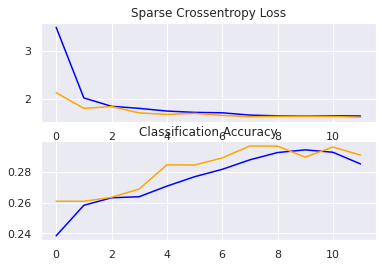

In [90]:
cnn= cnn_variable(opt2, input_variable_train2, input_variable_valid2, input_variable_test2)

In [92]:
def cnn_variable1(opt, inputs, input_variable_valid,input_variable_test):
  inputs = Input(shape=(None,33),name='inputs')
  inputs_L = Input(shape=[],name='inputs2')
  layer_c = Conv1D(8000, 1, padding="same")(inputs)
  layer = Activation("LeakyReLU")(layer_c)
  #layer = Dropout(0.5)(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  layer = Conv1D(4000, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  #layer = Dropout(0.2)(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  layer = Conv1D(2000, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  #layer = Dropout(0.2)(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  layer = Conv1D(1000, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  #layer = Dropout(0.2)(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  #layer = Dropout(0.2)(layer)
  #layer = Flatten()(layer)
  #layer = Dropout(0.2)(layer)
  layer = TimeDistributed(Dense(1500))(layer)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=15)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train2, validation_data=input_variable_valid2, batch_size=BS, epochs=NUM_EPOCHS, verbose=1, callbacks=[early_stopping])
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test2, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1]) 

In [93]:
cnn1= cnn_variable1(opt2, input_variable_train2, input_variable_valid2, input_variable_test2)

Epoch 1/100
1250/1250 [==============================] - 552s 393ms/step - loss: 2.1387 - sparse_categorical_accuracy: 0.2201 - val_loss: 1.9013 - val_sparse_categorical_accuracy: 0.2190
Epoch 2/100
1250/1250 [==============================] - 211s 168ms/step - loss: 1.8774 - sparse_categorical_accuracy: 0.2188 - val_loss: 1.8213 - val_sparse_categorical_accuracy: 0.2160
Epoch 3/100
1250/1250 [==============================] - 211s 168ms/step - loss: 1.8252 - sparse_categorical_accuracy: 0.2167 - val_loss: 1.7780 - val_sparse_categorical_accuracy: 0.2172
Epoch 4/100
1250/1250 [==============================] - 211s 169ms/step - loss: 1.7861 - sparse_categorical_accuracy: 0.2155 - val_loss: 1.7586 - val_sparse_categorical_accuracy: 0.2141
Epoch 5/100
1250/1250 [==============================] - 211s 169ms/step - loss: 1.7542 - sparse_categorical_accuracy: 0.2157 - val_loss: 1.7109 - val_sparse_categorical_accuracy: 0.2145
Epoch 6/100
1250/1250 [==============================] - 212s 169

KeyboardInterrupt: ignored

In [105]:
def cnn_variable2(opt, inputs, input_variable_valid,input_variable_test):
  inputs = Input(shape=(None,33),name='inputs')
  inputs_L = Input(shape=[],name='inputs2')
  layer_c = Conv1D(256, 1, padding="same")(inputs)
  layer = Activation("LeakyReLU")(layer_c)
  #layer = Dropout(0.5)(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  layer = Conv1D(128, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  #layer = Dropout(0.2)(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  layer = Conv1D(256, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  #layer = Dropout(0.2)(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  #layer = Dropout(0.2)(layer)
  #layer = Flatten()(layer)
  #layer = Dropout(0.2)(layer)
  layer = TimeDistributed(Dense(1500))(layer)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=150)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train2, validation_data=input_variable_valid2, batch_size=BS, epochs=NUM_EPOCHS, verbose=1, callbacks=[early_stopping])
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test2, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1]) 

In [106]:
cnn2= cnn_variable2(opt2, input_variable_train2, input_variable_valid2, input_variable_test2)

Epoch 1/100
1250/1250 [==============================] - 33s 24ms/step - loss: 2.3532 - sparse_categorical_accuracy: 0.2220 - val_loss: 1.8302 - val_sparse_categorical_accuracy: 0.2162
Epoch 2/100
1250/1250 [==============================] - 26s 21ms/step - loss: 1.7875 - sparse_categorical_accuracy: 0.2194 - val_loss: 1.7260 - val_sparse_categorical_accuracy: 0.2159
Epoch 3/100
1250/1250 [==============================] - 25s 20ms/step - loss: 1.7173 - sparse_categorical_accuracy: 0.2182 - val_loss: 1.6929 - val_sparse_categorical_accuracy: 0.2147
Epoch 4/100
 155/1250 [==>...........................] - ETA: 18s - loss: 1.6916 - sparse_categorical_accuracy: 0.2182

KeyboardInterrupt: ignored

In [109]:
def cnn_variable3(opt, inputs, input_variable_valid,input_variable_test):
  inputs = Input(shape=(None,33),name='inputs')
  inputs_L = Input(shape=[],name='inputs2')
  layer_c = Conv1D(256, 1, padding="same")(inputs)
  layer = Activation("LeakyReLU")(layer_c)
  #layer = Dropout(0.5)(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  layer = Conv1D(128, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  #layer = Dropout(0.2)(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  layer = Conv1D(256, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  #layer = Dropout(0.2)(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  layer = Conv1D(128, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  #layer = Dropout(0.2)(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  #layer = Dropout(0.2)(layer)
  #layer = Flatten()(layer)
  #layer = Dropout(0.2)(layer)
  layer = TimeDistributed(Dense(300))(layer)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=15)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train2, validation_data=input_variable_valid2, batch_size=BS, epochs=NUM_EPOCHS, verbose=1, callbacks=[early_stopping])
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test2, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1]) 

Epoch 1/100
1250/1250 [==============================] - 40s 30ms/step - loss: 2.6237 - sparse_categorical_accuracy: 0.2494 - val_loss: 2.0933 - val_sparse_categorical_accuracy: 0.2630
Epoch 2/100
1250/1250 [==============================] - 33s 26ms/step - loss: 2.0276 - sparse_categorical_accuracy: 0.2639 - val_loss: 1.9801 - val_sparse_categorical_accuracy: 0.2714
Epoch 3/100
1250/1250 [==============================] - 31s 25ms/step - loss: 1.9176 - sparse_categorical_accuracy: 0.2768 - val_loss: 1.8775 - val_sparse_categorical_accuracy: 0.2827
Epoch 4/100
1250/1250 [==============================] - 30s 24ms/step - loss: 1.8469 - sparse_categorical_accuracy: 0.2844 - val_loss: 1.8442 - val_sparse_categorical_accuracy: 0.2905
Epoch 5/100
1250/1250 [==============================] - 21s 17ms/step - loss: 1.8160 - sparse_categorical_accuracy: 0.2890 - val_loss: 1.8090 - val_sparse_categorical_accuracy: 0.2976
Epoch 6/100
1250/1250 [==============================] - 20s 16ms/step - lo

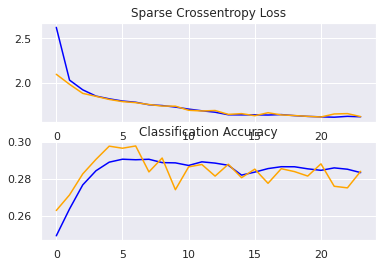

In [110]:
cnn3= cnn_variable3(opt2, input_variable_train2, input_variable_valid2, input_variable_test2)

In [112]:
NUM_EPOCHS = 100 #Increase epochs if you do not see a flatlined loss function
#Add batch normalization
INIT_LR  = 0.0001 #change to 0.001 after
BS = 32 #batch size
opt= SGD(learning_rate=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
opt2 = tf.optimizers.Adam(learning_rate = INIT_LR)
from keras.callbacks import EarlyStopping  
early_stopping1 =EarlyStopping(monitor='sparse_categorical_accuracy', patience=2) 

In [113]:
def cnn_variable4(opt, inputs, input_variable_valid,input_variable_test):
  inputs = Input(shape=(None,33),name='inputs')
  inputs_L = Input(shape=[],name='inputs2')
  layer_c = Conv1D(512, 1, padding="same")(inputs)
  layer = Activation("LeakyReLU")(layer_c)
  layer = Dropout(0.25)(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  layer = Conv1D(256, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  #layer = Dropout(0.2)(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  layer = Conv1D(512, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  #layer = Dropout(0.2)(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  layer = Conv1D(256, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  #layer = Dropout(0.2)(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  #layer = Dropout(0.2)(layer)
  #layer = Flatten()(layer)
  #layer = Dropout(0.2)(layer)
  layer = TimeDistributed(Dense(1000))(layer)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=100)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train2, validation_data=input_variable_valid2, batch_size=BS, epochs=NUM_EPOCHS, verbose=1, callbacks=[early_stopping1])
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test2, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1]) 

Epoch 1/100
1250/1250 [==============================] - 48s 37ms/step - loss: 3.9640 - sparse_categorical_accuracy: 0.2260 - val_loss: 2.1821 - val_sparse_categorical_accuracy: 0.2272
Epoch 2/100
1250/1250 [==============================] - 21s 17ms/step - loss: 2.0805 - sparse_categorical_accuracy: 0.2265 - val_loss: 1.8665 - val_sparse_categorical_accuracy: 0.2299
Epoch 3/100
1250/1250 [==============================] - 21s 17ms/step - loss: 1.8463 - sparse_categorical_accuracy: 0.2301 - val_loss: 1.7778 - val_sparse_categorical_accuracy: 0.2315
Epoch 4/100
1250/1250 [==============================] - 21s 17ms/step - loss: 1.7679 - sparse_categorical_accuracy: 0.2324 - val_loss: 1.7169 - val_sparse_categorical_accuracy: 0.2326
Epoch 5/100
1250/1250 [==============================] - 34s 27ms/step - loss: 1.7134 - sparse_categorical_accuracy: 0.2339 - val_loss: 1.6735 - val_sparse_categorical_accuracy: 0.2344
Epoch 6/100
1250/1250 [==============================] - 32s 26ms/step - lo

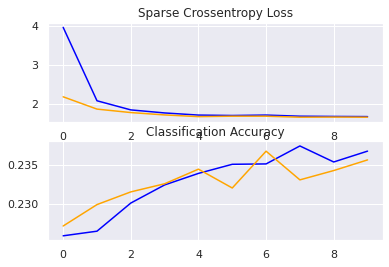

In [114]:
cnn4= cnn_variable4(opt2, input_variable_train2, input_variable_valid2, input_variable_test2)

In [122]:
def cnn_variable5(opt, inputs, input_variable_valid,input_variable_test):
  inputs = Input(shape=(None,33),name='inputs')
  inputs_L = Input(shape=[],name='inputs2')
  layer_c = Conv1D(128, 1, padding="same")(inputs)
  layer = Activation("LeakyReLU")(layer_c)
  #layer = Dropout(0.5)(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  layer = Conv1D(64, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  #layer = Dropout(0.2)(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  layer = Conv1D(128, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  layer = Conv1D(256, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  #layer = Dropout(0.2)(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  #layer = Dropout(0.2)(layer)
  #layer = Flatten()(layer)
  #layer = Dropout(0.2)(layer)
  layer = TimeDistributed(Dense(300))(layer)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=15)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train2, validation_data=input_variable_valid2, batch_size=BS, epochs=NUM_EPOCHS, verbose=1, callbacks=[early_stopping])
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test2, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1]) 

Epoch 1/100
1250/1250 [==============================] - 57s 44ms/step - loss: 2.5384 - sparse_categorical_accuracy: 0.2536 - val_loss: 2.0711 - val_sparse_categorical_accuracy: 0.2664
Epoch 2/100
1250/1250 [==============================] - 26s 21ms/step - loss: 2.0309 - sparse_categorical_accuracy: 0.2624 - val_loss: 1.8932 - val_sparse_categorical_accuracy: 0.2707
Epoch 3/100
1250/1250 [==============================] - 26s 21ms/step - loss: 1.9215 - sparse_categorical_accuracy: 0.2676 - val_loss: 1.8608 - val_sparse_categorical_accuracy: 0.2790
Epoch 4/100
1250/1250 [==============================] - 31s 25ms/step - loss: 1.8891 - sparse_categorical_accuracy: 0.2718 - val_loss: 1.8338 - val_sparse_categorical_accuracy: 0.2776
Epoch 5/100
1250/1250 [==============================] - 26s 21ms/step - loss: 1.8467 - sparse_categorical_accuracy: 0.2750 - val_loss: 1.7984 - val_sparse_categorical_accuracy: 0.2835
Epoch 6/100
1250/1250 [==============================] - 20s 16ms/step - lo

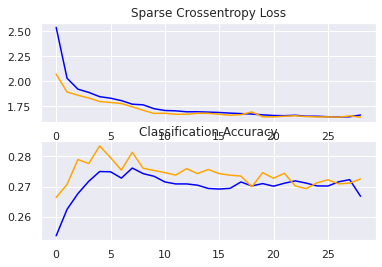

In [123]:
cnn5= cnn_variable5(opt2, input_variable_train2, input_variable_valid2, input_variable_test2)

In [124]:
def cnn_variable6(opt, inputs, input_variable_valid,input_variable_test):
  inputs = Input(shape=(None,33),name='inputs')
  inputs_L = Input(shape=[],name='inputs2')
  layer_c = Conv1D(256, 1, padding="same")(inputs)
  layer = Activation("LeakyReLU")(layer_c)
  #layer = Dropout(0.5)(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  layer = Conv1D(128, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  #layer = Dropout(0.2)(layer)
  layer = Conv1D(64, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  #layer = Dropout(0.2)(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  layer = Conv1D(128, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  layer = Conv1D(256, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  #layer = Dropout(0.2)(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  #layer = Dropout(0.2)(layer)
  #layer = Flatten()(layer)
  #layer = Dropout(0.2)(layer)
  layer = TimeDistributed(Dense(600))(layer)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=15)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train2, validation_data=input_variable_valid2, batch_size=BS, epochs=NUM_EPOCHS, verbose=1, callbacks=[early_stopping])
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test2, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1]) 

Epoch 1/100
1250/1250 [==============================] - 22s 17ms/step - loss: 2.2149 - sparse_categorical_accuracy: 0.2423 - val_loss: 1.7937 - val_sparse_categorical_accuracy: 0.2544
Epoch 2/100
1250/1250 [==============================] - 21s 17ms/step - loss: 1.7706 - sparse_categorical_accuracy: 0.2497 - val_loss: 1.7144 - val_sparse_categorical_accuracy: 0.2531
Epoch 3/100
1250/1250 [==============================] - 21s 16ms/step - loss: 1.7126 - sparse_categorical_accuracy: 0.2520 - val_loss: 1.7002 - val_sparse_categorical_accuracy: 0.2573
Epoch 4/100
1250/1250 [==============================] - 21s 17ms/step - loss: 1.6951 - sparse_categorical_accuracy: 0.2538 - val_loss: 1.6735 - val_sparse_categorical_accuracy: 0.2593
Epoch 5/100
1250/1250 [==============================] - 22s 17ms/step - loss: 1.6828 - sparse_categorical_accuracy: 0.2561 - val_loss: 1.6780 - val_sparse_categorical_accuracy: 0.2602
Epoch 6/100
1250/1250 [==============================] - 21s 16ms/step - lo

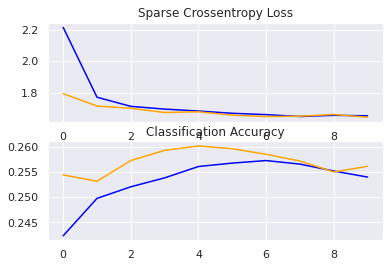

In [125]:
cnn6= cnn_variable6(opt2, input_variable_train2, input_variable_valid2, input_variable_test2)

In [82]:
def cnn_variable_k(opt, inputs, input_variable_valid,input_variable_test):
  inputs = Input(shape=(None,129),name='inputs')
  inputs_L = Input(shape=[],name='inputs2')
  layer_c = Conv1D(512, 1, padding="same")(inputs)
  layer = Activation("LeakyReLU")(layer_c)
  #layer = BatchNormalization(axis=-1)(layer)
  #layer = Dropout(0.25)(layer)
  #layer = Conv1D(512, 1, padding="same")(layer)
  #layer = BatchNormalization(axis=-1)(layer)
  #layer = Dropout(0.1)(layer)
  #layer = Activation("LeakyReLU")(layer)
  layer = Conv1D(256, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  #layer = Dropout(0.1)(layer)
  layer = Activation("LeakyReLU")(layer)
  #layer = Conv1D(128, 1, padding="same")(layer)
  #layer = BatchNormalization(axis=-1)(layer)
 # layer = Dropout(0.1)(layer)
 # layer = Activation("LeakyReLU")(layer)
  #layer = Conv1D(256, 1, padding="same")(layer)
 # layer = BatchNormalization(axis=-1)(layer)
 # layer = Activation("LeakyReLU")(layer)
#  layer = Dropout(0.1)(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  #layer = Flatten()(layer)
  #layer = Dropout(0.2)(layer)
  layer = TimeDistributed(Dense(1500))(layer)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=15)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train, validation_data=input_variable_valid, batch_size=BS, epochs=NUM_EPOCHS, verbose=1)
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1]) 

In [ ]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[
2],x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()


In [57]:
inputs = Input(shape=(None,129),name='inputs')
inputs_all = Input(shape=[], name='inputs2')
inputs_variable=(inputs,inputs_all)
inputs_variable[0]

<KerasTensor: shape=(None, None, 129) dtype=float32 (created by layer 'inputs')>

In [77]:
def cnn_variable_s(opt, inputs, input_variable_valid,input_variable_test):
  inputs = Input(shape=(None,129),name='inputs')
  inputs_L = Input(shape=[],name='inputs2')
  layer_c = Conv1D(256, 1, padding="same")(inputs)
  layer = Activation("LeakyReLU")(layer_c)
  layer = MaxPooling1D(pool_size = 2)(layer)
  #layer = Dropout(0.2)(layer)
  layer = Conv1D(128, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  layer = Conv1D(256, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  #layer = Dropout(0.2)(layer)
  #layer = Flatten()(layer)
  #layer = Dropout(0.2)(layer)
  layer = TimeDistributed(Dense(150))(layer)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=15)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train, validation_data=input_variable_valid, batch_size=BS, epochs=NUM_EPOCHS, verbose=1)
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1]) 

#### Run the model

In [78]:
cnn= cnn_variable_s(opt2, input_variable_train, input_variable_valid,input_variable_test)

Epoch 1/100
1250/1250 [==============================] - 148s 117ms/step - loss: 2.3021 - sparse_categorical_accuracy: 0.2493 - val_loss: 1.7733 - val_sparse_categorical_accuracy: 0.2639
Epoch 2/100
1250/1250 [==============================] - 146s 117ms/step - loss: 1.7716 - sparse_categorical_accuracy: 0.2661 - val_loss: 1.7095 - val_sparse_categorical_accuracy: 0.2758
Epoch 3/100
1250/1250 [==============================] - 147s 117ms/step - loss: 1.7344 - sparse_categorical_accuracy: 0.2750 - val_loss: 1.6768 - val_sparse_categorical_accuracy: 0.2868
Epoch 4/100
1250/1250 [==============================] - 145s 116ms/step - loss: 1.6971 - sparse_categorical_accuracy: 0.2837 - val_loss: 1.6538 - val_sparse_categorical_accuracy: 0.2956
Epoch 5/100
 213/1250 [====>.........................] - ETA: 1:53 - loss: 1.6802 - sparse_categorical_accuracy: 0.2885

KeyboardInterrupt: ignored

In [67]:
inputs = Input(shape=(None,65),name='inputs')
inputs_all = Input(shape=[], name='inputs2')
inputs_variable=(inputs,inputs_all)
inputs_variable[0]

<KerasTensor: shape=(None, None, 65) dtype=float32 (created by layer 'inputs')>

In [ ]:
def cnn_variable_s1(opt, inputs, input_variable_valid,input_variable_test):
  inputs = Input(shape=(None,65),name='inputs')
  inputs_L = Input(shape=[],name='inputs2')
  layer_c = Conv1D(256, 1, padding="same")(inputs)
  layer = Activation("LeakyReLU")(layer_c)
  layer = MaxPooling1D(pool_size = 2)(layer)
  #layer = Dropout(0.2)(layer)
  layer = Conv1D(128, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  layer = Conv1D(256, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  #layer = Dropout(0.2)(layer)
  #layer = Flatten()(layer)
  #layer = Dropout(0.2)(layer)
  layer = TimeDistributed(Dense(150))(layer)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=15)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train1, validation_data=input_variable_valid1, batch_size=BS, epochs=NUM_EPOCHS, verbose=1)
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test1, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1]) 

In [ ]:
cnn2= cnn_variable_s1(opt2, input_variable_train1, input_variable_valid1,input_variable_test1)

In [75]:
def cnn_variable_s2(opt, inputs, input_variable_valid,input_variable_test):
  inputs = Input(shape=(None,33),name='inputs')
  inputs_L = Input(shape=[],name='inputs2')
  layer_c = Conv1D(256, 1, padding="same")(inputs)
  layer = Activation("LeakyReLU")(layer_c)
  layer = MaxPooling1D(pool_size = 2)(layer)
  #layer = Dropout(0.2)(layer)
  layer = Conv1D(128, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  layer = Conv1D(256, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  #layer = Dropout(0.2)(layer)
  #layer = Flatten()(layer)
  #layer = Dropout(0.2)(layer)
  layer = TimeDistributed(Dense(150))(layer)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=15)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train2, validation_data=input_variable_valid2, batch_size=BS, epochs=NUM_EPOCHS, verbose=1)
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test2, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1]) 

In [76]:
cnn3= cnn_variable_s2(opt2, input_variable_train2, input_variable_valid2, input_variable_test2)

Epoch 1/100
1250/1250 [==============================] - 534s 425ms/step - loss: 2.6270 - sparse_categorical_accuracy: 0.2536 - val_loss: 1.8544 - val_sparse_categorical_accuracy: 0.2783
Epoch 2/100
1250/1250 [==============================] - 105s 84ms/step - loss: 1.8617 - sparse_categorical_accuracy: 0.2758 - val_loss: 1.7414 - val_sparse_categorical_accuracy: 0.2961
Epoch 3/100
1250/1250 [==============================] - 107s 86ms/step - loss: 1.7892 - sparse_categorical_accuracy: 0.2890 - val_loss: 1.7203 - val_sparse_categorical_accuracy: 0.3054
Epoch 4/100
1250/1250 [==============================] - 109s 87ms/step - loss: 1.7406 - sparse_categorical_accuracy: 0.2983 - val_loss: 1.6822 - val_sparse_categorical_accuracy: 0.3118
Epoch 5/100
1250/1250 [==============================] - 108s 86ms/step - loss: 1.7034 - sparse_categorical_accuracy: 0.3039 - val_loss: 1.6576 - val_sparse_categorical_accuracy: 0.3229
Epoch 6/100
1250/1250 [==============================] - 108s 86ms/st

KeyboardInterrupt: ignored

In [108]:
def cnn_variable_s22(opt, inputs, input_variable_valid,input_variable_test):
  inputs = Input(shape=(None,33),name='inputs')
  inputs_L = Input(shape=[],name='inputs2')
  layer_c = Conv1D(512, 1, padding="same")(inputs)
  layer = BatchNormalization(axis=-1)(layer_c)
  layer = Activation("LeakyReLU")(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  #layer = Dropout(0.2)(layer)
  #layer = TimeDistributed(Conv1D(512, 1, padding="same"))(layer)
  layer = Conv1D(256, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  layer = Conv1D(512, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  #layer = Conv1D(256, 1, padding="same")(layer)
 # layer = BatchNormalization(axis=-1)(layer)
 # layer = Activation("LeakyReLU")(layer)
 # layer = Conv1D(512, 1, padding="same")(layer)
  #layer = BatchNormalization(axis=-1)(layer)
 # layer = Activation("LeakyReLU")(layer)
  #layer = MaxPooling1D(pool_size = 2)(layer)
  #layer = Dropout(0.2)(layer)
  #layer = Flatten()(layer)
  #layer = Dropout(0.2)(layer)
  layer = TimeDistributed(Dense(300))(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  #layer = MaxPooling1D(pool_size = 2)(layer)
  layer = TimeDistributed(Dense(150))(layer) #TimeDistributed layer apply the same layer to several inputs. And it produce one output per input to get the result in time
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=150)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train2, validation_data=input_variable_valid2, batch_size=BS, epochs=NUM_EPOCHS, verbose=1)
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test2, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1]) 

In [109]:
cnn22= cnn_variable_s22(opt2, input_variable_train2, input_variable_valid2, input_variable_test2)

Epoch 1/100
1250/1250 [==============================] - 327s 258ms/step - loss: 3.3299 - sparse_categorical_accuracy: 0.2291 - val_loss: 2.2058 - val_sparse_categorical_accuracy: 0.2391


KeyboardInterrupt: ignored

In [122]:
def cnn_variable_s23(opt, inputs, input_variable_valid,input_variable_test):
  inputs = Input(shape=(None,33),name='inputs')
  inputs_L = Input(shape=[],name='inputs2')
  layer_c = Conv1D(512, 4, padding="same")(inputs)
  layer = Activation("LeakyReLU")(layer_c)
  layer = MaxPooling1D(pool_size = 2)(layer)
  #layer = Dropout(0.2)(layer)
  layer = Conv1D(256, 4, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  layer = Conv1D(128, 4, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  layer = Conv1D(256, 4, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  layer = Conv1D(128, 4, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Conv1D(256, 4, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  #layer = MaxPooling1D(pool_size = 2)(layer)
  #layer = Dropout(0.2)(layer)
  #layer = Flatten()(layer)
  #layer = Dropout(0.2)(layer)
  layer = TimeDistributed(Dense(250))(layer)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=150)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train2, validation_data=input_variable_valid2, batch_size=BS, epochs=NUM_EPOCHS, verbose=1)
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test2, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1]) 

In [1]:
cnn23= cnn_variable_s23(opt2, input_variable_train2, input_variable_valid2, input_variable_test2)

NameError: ignored

In [125]:
def cnn_variable_s24(opt, inputs, input_variable_valid,input_variable_test):
  inputs = Input(shape=(None,33),name='inputs')
  inputs_L = Input(shape=[],name='inputs2')
  layer_c = Conv1D(512, 1, padding="same")(inputs)
  layer = Activation("LeakyReLU")(layer_c)
  layer = MaxPooling1D(pool_size = 2)(layer)
  #layer = Dropout(0.2)(layer)
  layer = Conv1D(256, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  layer = Conv1D(128, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  layer = Conv1D(256, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  #layer = Dropout(0.2)(layer)
  #layer = Flatten()(layer)
  #layer = Dropout(0.2)(layer)
  layer = TimeDistributed(Dense(1500))(layer)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=15)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train2, validation_data=input_variable_valid2, batch_size=BS, epochs=NUM_EPOCHS, verbose=1)
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test2, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1]) 



## Transformers

In [134]:
NUM_EPOCHS = 100 #Increase epochs if you do not see a flatlined loss function
#Add batch normalization
INIT_LR  = 0.0001 #change to 0.001 after
BS = 32 #batch size
opt= SGD(learning_rate=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
opt2 = tf.optimizers.Adam(learning_rate = INIT_LR)
from keras.callbacks import EarlyStopping  
early_stopping =EarlyStopping(monitor='sparse_categorical_accuracy', patience=2) 

In [135]:
def transformer_variable(opt, inputs, input_variable_valid,input_variable_test):
  inputs = keras.Input(shape=(None, 33))
  inputs_L = Input(shape=[])
  embDim = 10
  newEmb = layers.TimeDistributed(layers.Dense(embDim))(inputs)
  inputsPosEmb = PositionEmbedding(maxlen=50000, embed_dim=embDim)(newEmb)
  transf1 = TransformerBlock(embed_dim=embDim, num_heads=4, ff_dim=4)(inputsPosEmb)
  transf2 =TransformerBlock(embed_dim=embDim, num_heads=4, ff_dim=4)(transf1)
  layer = layers.TimeDistributed(layers.Dense(150))(transf2)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=10)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train2, validation_data=input_variable_valid2, batch_size=BS, epochs=NUM_EPOCHS, verbose=1,callbacks=[early_stopping] )
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test2, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1])

Epoch 1/100
1250/1250 [==============================] - 51s 38ms/step - loss: 6.2631 - sparse_categorical_accuracy: 0.2088 - val_loss: 4.4952 - val_sparse_categorical_accuracy: 0.2144
Epoch 2/100
1250/1250 [==============================] - 45s 36ms/step - loss: 3.7119 - sparse_categorical_accuracy: 0.2246 - val_loss: 2.6103 - val_sparse_categorical_accuracy: 0.2391
Epoch 3/100
1250/1250 [==============================] - 36s 28ms/step - loss: 2.5512 - sparse_categorical_accuracy: 0.2361 - val_loss: 2.0434 - val_sparse_categorical_accuracy: 0.2501
Epoch 4/100
1250/1250 [==============================] - 35s 28ms/step - loss: 2.0790 - sparse_categorical_accuracy: 0.2482 - val_loss: 1.8399 - val_sparse_categorical_accuracy: 0.2716
Epoch 5/100
1250/1250 [==============================] - 36s 29ms/step - loss: 1.9093 - sparse_categorical_accuracy: 0.2636 - val_loss: 1.8105 - val_sparse_categorical_accuracy: 0.2807
Epoch 6/100
1250/1250 [==============================] - 36s 28ms/step - lo

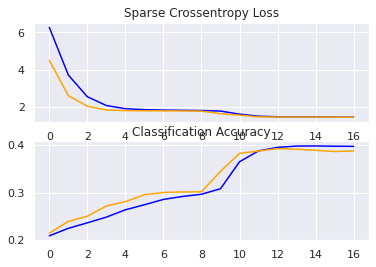

In [136]:
transformer= transformer_variable(opt2, input_variable_train2, input_variable_valid2, input_variable_test2)

In [137]:
def transformer_variable1(opt, inputs, input_variable_valid,input_variable_test):
  inputs = keras.Input(shape=(None, 33))
  inputs_L = Input(shape=[])
  embDim = 10 ## Embedding size for each token
  newEmb = layers.TimeDistributed(layers.Dense(embDim))(inputs)
  inputsPosEmb = PositionEmbedding(maxlen=50000, embed_dim=embDim)(newEmb)
  transf1 = TransformerBlock(embed_dim=embDim, num_heads=4, ff_dim=32)(inputsPosEmb) #ff_dim # Hidden layer size in feed forward network inside transformer
  transf2 =TransformerBlock(embed_dim=embDim, num_heads=4, ff_dim=32)(transf1)
  layer = layers.TimeDistributed(layers.Dense(150))(transf2)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=10)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train2, validation_data=input_variable_valid2, batch_size=BS, epochs=NUM_EPOCHS, verbose=1,callbacks=[early_stopping] )
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test2, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1])

Epoch 1/100
1250/1250 [==============================] - 37s 28ms/step - loss: 2.8769 - sparse_categorical_accuracy: 0.2354 - val_loss: 2.0933 - val_sparse_categorical_accuracy: 0.2616
Epoch 2/100
1250/1250 [==============================] - 35s 28ms/step - loss: 2.0706 - sparse_categorical_accuracy: 0.2585 - val_loss: 1.9851 - val_sparse_categorical_accuracy: 0.2747
Epoch 3/100
1250/1250 [==============================] - 35s 28ms/step - loss: 2.0082 - sparse_categorical_accuracy: 0.2669 - val_loss: 1.9747 - val_sparse_categorical_accuracy: 0.2768
Epoch 4/100
1250/1250 [==============================] - 35s 28ms/step - loss: 1.9912 - sparse_categorical_accuracy: 0.2724 - val_loss: 1.9669 - val_sparse_categorical_accuracy: 0.2788
Epoch 5/100
1250/1250 [==============================] - 36s 28ms/step - loss: 1.9823 - sparse_categorical_accuracy: 0.2751 - val_loss: 1.9593 - val_sparse_categorical_accuracy: 0.2805
Epoch 6/100
1250/1250 [==============================] - 35s 28ms/step - lo

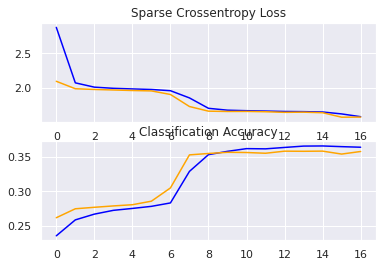

In [138]:
transformer1= transformer_variable1(opt2, input_variable_train2, input_variable_valid2, input_variable_test2)

In [139]:
def transformer_variable2(opt, inputs, input_variable_valid,input_variable_test):
  inputs = keras.Input(shape=(None, 33))
  inputs_L = Input(shape=[])
  embDim = 32 ## Embedding size for each token
  newEmb = layers.TimeDistributed(layers.Dense(embDim))(inputs)
  inputsPosEmb = PositionEmbedding(maxlen=50000, embed_dim=embDim)(newEmb)
  transf1 = TransformerBlock(embed_dim=embDim, num_heads=4, ff_dim=32)(inputsPosEmb) #ff_dim # Hidden layer size in feed forward network inside transformer
  transf2 =TransformerBlock(embed_dim=embDim, num_heads=4, ff_dim=32)(transf1)
  layer = layers.TimeDistributed(layers.Dense(150))(transf2)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=10)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train2, validation_data=input_variable_valid2, batch_size=BS, epochs=NUM_EPOCHS, verbose=1,callbacks=[early_stopping] )
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test2, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1])

Epoch 1/100
1250/1250 [==============================] - 41s 31ms/step - loss: 2.3852 - sparse_categorical_accuracy: 0.2438 - val_loss: 1.6671 - val_sparse_categorical_accuracy: 0.2835
Epoch 2/100
1250/1250 [==============================] - 38s 30ms/step - loss: 1.6826 - sparse_categorical_accuracy: 0.2828 - val_loss: 1.6516 - val_sparse_categorical_accuracy: 0.3011
Epoch 3/100
1250/1250 [==============================] - 39s 31ms/step - loss: 1.6563 - sparse_categorical_accuracy: 0.2966 - val_loss: 1.6136 - val_sparse_categorical_accuracy: 0.3100
Epoch 4/100
1250/1250 [==============================] - 38s 31ms/step - loss: 1.5844 - sparse_categorical_accuracy: 0.3189 - val_loss: 1.5273 - val_sparse_categorical_accuracy: 0.3448
Epoch 5/100
1250/1250 [==============================] - 37s 30ms/step - loss: 1.5076 - sparse_categorical_accuracy: 0.3466 - val_loss: 1.4417 - val_sparse_categorical_accuracy: 0.3570
Epoch 6/100
1250/1250 [==============================] - 41s 33ms/step - lo

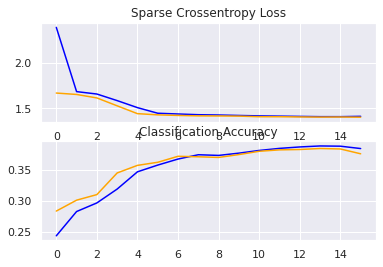

In [140]:
transformer2= transformer_variable2(opt2, input_variable_train2, input_variable_valid2, input_variable_test2)

In [143]:
def transformer_variable3(opt, inputs, input_variable_valid,input_variable_test):
  inputs = keras.Input(shape=(None, 33))
  inputs_L = Input(shape=[])
  embDim = 64 ## Embedding size for each token
  newEmb = layers.TimeDistributed(layers.Dense(embDim))(inputs)
  inputsPosEmb = PositionEmbedding(maxlen=50000, embed_dim=embDim)(newEmb)
  transf1 = TransformerBlock(embed_dim=embDim, num_heads=4, ff_dim=32)(inputsPosEmb) #ff_dim # Hidden layer size in feed forward network inside transformer
  transf2 =TransformerBlock(embed_dim=embDim, num_heads=4, ff_dim=32)(transf1)
  layer = layers.TimeDistributed(layers.Dense(150))(transf2)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=10)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train2, validation_data=input_variable_valid2, batch_size=BS, epochs=NUM_EPOCHS, verbose=1,callbacks=[early_stopping] )
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test2, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1])

Epoch 1/100
1250/1250 [==============================] - 43s 32ms/step - loss: 2.2344 - sparse_categorical_accuracy: 0.2607 - val_loss: 1.8657 - val_sparse_categorical_accuracy: 0.2847
Epoch 2/100
1250/1250 [==============================] - 40s 32ms/step - loss: 1.8608 - sparse_categorical_accuracy: 0.2789 - val_loss: 1.7252 - val_sparse_categorical_accuracy: 0.2649
Epoch 3/100
1250/1250 [==============================] - 39s 31ms/step - loss: 1.6996 - sparse_categorical_accuracy: 0.2860 - val_loss: 1.6592 - val_sparse_categorical_accuracy: 0.2902
Epoch 4/100
1250/1250 [==============================] - 39s 31ms/step - loss: 1.6384 - sparse_categorical_accuracy: 0.3087 - val_loss: 1.5533 - val_sparse_categorical_accuracy: 0.3120
Epoch 5/100
1250/1250 [==============================] - 39s 31ms/step - loss: 1.5740 - sparse_categorical_accuracy: 0.3131 - val_loss: 1.5494 - val_sparse_categorical_accuracy: 0.3161
Epoch 6/100
1250/1250 [==============================] - 39s 31ms/step - lo

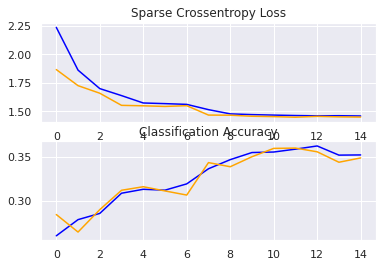

In [144]:
transformer3= transformer_variable3(opt2, input_variable_train2, input_variable_valid2, input_variable_test2)

In [25]:
def transformer_variable4(opt, inputs, input_variable_valid,input_variable_test):
  inputs = keras.Input(shape=(None, 33))
  inputs_L = Input(shape=[])
  embDim = 64 ## Embedding size for each token
  newEmb = layers.TimeDistributed(layers.Dense(embDim))(inputs)
  inputsPosEmb = PositionEmbedding(maxlen=50000, embed_dim=embDim)(newEmb)
  transf1 = TransformerBlock(embed_dim=embDim, num_heads=8, ff_dim=64)(inputsPosEmb) #ff_dim # Hidden layer size in feed forward network inside transformer
  transf2 =TransformerBlock(embed_dim=embDim, num_heads=8, ff_dim=64)(transf1)
  layer = layers.TimeDistributed(layers.Dense(150))(transf2)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=10)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train2, validation_data=input_variable_valid2, batch_size=BS, epochs=NUM_EPOCHS, verbose=1,callbacks=[early_stopping] )
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test2, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1])

In [ ]:
transformer4= transformer_variable4(opt2, input_variable_train2, input_variable_valid2, input_variable_test2)

Epoch 1/100
1250/1250 [==============================] - 2756s 2s/step - loss: 2.7589 - sparse_categorical_accuracy: 0.2291 - val_loss: 1.9090 - val_sparse_categorical_accuracy: 0.2598
Epoch 2/100
1250/1250 [==============================] - 2799s 2s/step - loss: 1.9231 - sparse_categorical_accuracy: 0.2560 - val_loss: 1.8826 - val_sparse_categorical_accuracy: 0.2752
Epoch 3/100
 836/1250 [===================>..........] - ETA: 14:34 - loss: 1.8779 - sparse_categorical_accuracy: 0.2661

Try this one as well: number of heads 8, dff 256, 